# Durable Consumption Model

## Model equations

The **states** are:

1. the persistent component of income, $p_t$
2. stock of the durable good, $n_t$
3. cash-on-hand, $m_t$

The **choices** are:

1. durable consumption, $d_t$
2. non-durable consumption, $c_t$

**Utility** is CRRA over a Cobb-Douglas aggregate:

$$ u(c_{t},d_{t})=\frac{(c_{t}^{\alpha}(d_{t}+\underline{d})^{1-\alpha})^{1-\rho}}{1-\rho} $$

**Income** follows a persistent-transitory process:

$$
\begin{aligned}
p_{t+1}&=\psi_{t+1}p_{t}^{\lambda},\,\,\,\log\psi_{t+1}\sim\mathcal{N}(-0.5\sigma_{\psi}^{2},\sigma_{\psi}^{2}) \\ y_{t+1}&=\xi_{t+1}p_{t+1},\,\,\,\log\xi_{t+1}\sim\mathcal{N}(-0.5\sigma_{\xi}^{2},\sigma_{\xi}^{2})
\end{aligned} 
$$

The household **cannot borrow** and the **interest rate** on savings is $r$. Adjusting the stock of durables is subject to a **proportional adjustment cost** $\tau$ and **durables depreciates** with a rate of $\delta$.

$$ n_{t+1}=(1-\delta)d_{t} $$

The **bellman equation** is

$$
\begin{aligned}
v_{t}(p_{t},n_{t},m_{t})&=\max\{v_{t}^{keep}(p_{t},n_{t},m_{t}),v_{t}^{adj.}(p_{t},x_{t})\}\\&\text{s.t.}&\\x_{t}&=&m_{t}+(1-\tau)n_{t}
\end{aligned} 
$$

 where
 
$$
\begin{aligned}
v_{t}^{keep}(p_{t},n_{t},m_{t})&=\max_{c_{t}}u(c_{t},n_{t})+\beta\mathbb{E}_{t}[v_{t+1}(p_{t+1},n_{t+1},m_{t+1})]\\&\text{s.t.}&\\
a_{t}&= m_{t}-c_{t}\\
m_{t+1}&= (1+r)a_{t}+y_{t+1}\\
n_{t+1}&= (1-\delta)n_{t}\\
a_{t}&\geq 0
\end{aligned} 
$$

and
 
$$
\begin{aligned}
v_{t}^{adj.}(p_{t},x_{t})&= \max_{c_{t},d_{t}}u(c_{t},d_{t})+\beta\mathbb{E}_{t}[v_{t+1}(p_{t+1},n_{t+1},m_{t+1})]\\&\text{s.t.}&\\
a_{t}&= x_{t}-c_{t}-d_{t}\\
m_{t+1}&= (1+r)a_{t}+y_{t+1}\\ 
n_{t+1}&= (1-\delta)n_{t}\\
a_{t}&\geq 0
\end{aligned} 
$$


# Setup

In [5]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Choose number of threads in numba

In [6]:
import numba as nb
nb.set_num_threads(8)

# NVFI - nested value function iteration

Define the **post-decision value function** as

$$ w_{t}(p_{t},n_{t},a_{t}) = \beta \mathbb{E}_{t}[v_{t+1}(m_{t+1},n_{t+1},p_{t+1})] $$

The **keeper problem** can then be written:

$$
\begin{aligned}
v_{t}^{keep}(p_{t},n_{t},m_{t})&=\max_{c_{t}}u(c_{t},n_{t})+ w_{t}(p_{t},n_{t},a_{t})]\\&\text{s.t.}&\\a_{t}&=&m_{t}-c_{t}\geq0
\end{aligned}
$$

The **adjuster problem** can further be written:

$$
\begin{aligned}
v_{t}^{adj.}(x_{t})&=\max_{d_{t}}v_{t}^{keep}(p_{t},d_{t},n_{t})\\&\text{s.t.}&\\m_{t}&=&x_{t}-d_{t}
\end{aligned}
$$

**NVFI** solves this reformulated problem.

In [14]:
model_nvfi = DurableConsumptionModelClass(name='example_nvfi',par={'solmethod':'nvfi','do_print':True})
model_nvfi.precompile_numba() # solve with very coarse grids
model_nvfi.solve()
model_nvfi.simulate()

numba precompiled in 14.3 secs
 t = 89 solved in 0.1 secs
  w computed in 2.3 secs
  solved keeper problem in 1.3 secs
  solved adjuster problem in 0.0 secs
 t = 88 solved in 3.7 secs
  w computed in 2.3 secs
  solved keeper problem in 1.3 secs
  solved adjuster problem in 0.0 secs
 t = 87 solved in 7.4 secs
  w computed in 2.3 secs
  solved keeper problem in 1.3 secs
  solved adjuster problem in 0.0 secs
 t = 86 solved in 11.0 secs
  w computed in 2.3 secs
  solved keeper problem in 1.3 secs
  solved adjuster problem in 0.0 secs
 t = 85 solved in 14.6 secs
  w computed in 2.3 secs
  solved keeper problem in 1.3 secs
  solved adjuster problem in 0.0 secs
 t = 84 solved in 18.2 secs
  w computed in 2.3 secs
  solved keeper problem in 1.3 secs
  solved adjuster problem in 0.0 secs
 t = 83 solved in 21.9 secs
  w computed in 2.3 secs
  solved keeper problem in 1.3 secs
  solved adjuster problem in 0.0 secs
 t = 82 solved in 25.5 secs
  w computed in 2.3 secs
  solved keeper problem in 1.3

**Plot** interactive decision functions:

In [19]:
model_nvfi.decision_functions()

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

**Plot** life-cycle profiles:

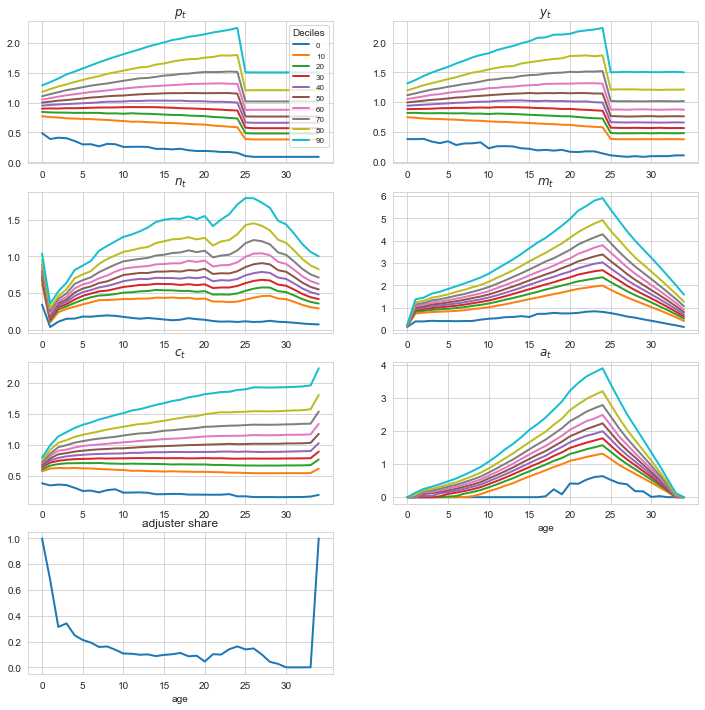

In [20]:
model_nvfi.lifecycle(deciles=True)

# NEGM - nested endogenous grid method

Define the **post-decision marginal value of cash:**

$$
\begin{aligned}
q_{t}(p_{t},d_{t},a_{t})&=\beta R\mathbb{E}_{t}[u_{c}(c_{t+1},d_{t+1})]\\
&=&\beta R\mathbb{E}_{t}[\alpha c_{t+1}^{\alpha(1-\rho)-1}d_{t+1}^{(1-\alpha)(1-\rho)}]
\end{aligned}
$$

Note that all optimal interior consumption choices must satisfy the **Euler-equation**

$$
\begin{aligned}
u_{c}(c_{t},d_{t})=\alpha c_{t}^{\alpha(1-\rho)-1}d_{t}^{(1-\alpha)(1-\rho)}&=q(p_{t},d_{t},a_{t})
\end{aligned}
$$

This implies that we have an analytical mapping from the post-decision space $(p_t,d_t,a_t)$ to consumption and cash-on-hand $(c_t,m_t)$:

$$
\begin{aligned}
c_{t} &=\frac{1}{\alpha}\left(\frac{q(a_{t},d_{t},p_{t})}{d_{t}^{(1-\alpha)(1-\rho)}}\right)^{\alpha(1-\rho)-1}
\\
m_{t} &= a_{t}+c_{t}
\end{aligned}
$$

**NEGM** uses this mapping (and an upperenvelope algorithm) to solve the keeper problem much faster.

In [13]:
model_negm = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','do_print':True})
model_negm.precompile_numba() # solve with very coarse grids
model_negm.solve()
model_negm.simulate()

numba precompiled in 15.8 secs
 t = 89 solved in 0.1 secs
  w computed in 3.7 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 88 solved in 3.8 secs
  w computed in 3.7 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 87 solved in 7.6 secs
  w computed in 3.7 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 86 solved in 11.4 secs
  w computed in 3.7 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 85 solved in 15.2 secs
  w computed in 3.7 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 84 solved in 19.0 secs
  w computed in 3.8 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 83 solved in 22.9 secs
  w computed in 3.8 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 82 solved in 26.8 secs
  w computed in 3.7 secs
  solved keeper problem in 0.1

**Plot** interactive decision functions:

In [9]:
model_negm.decision_functions()

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4), value=0), Dropdown(description='ip', …

**Plot** life-cycle profiles:

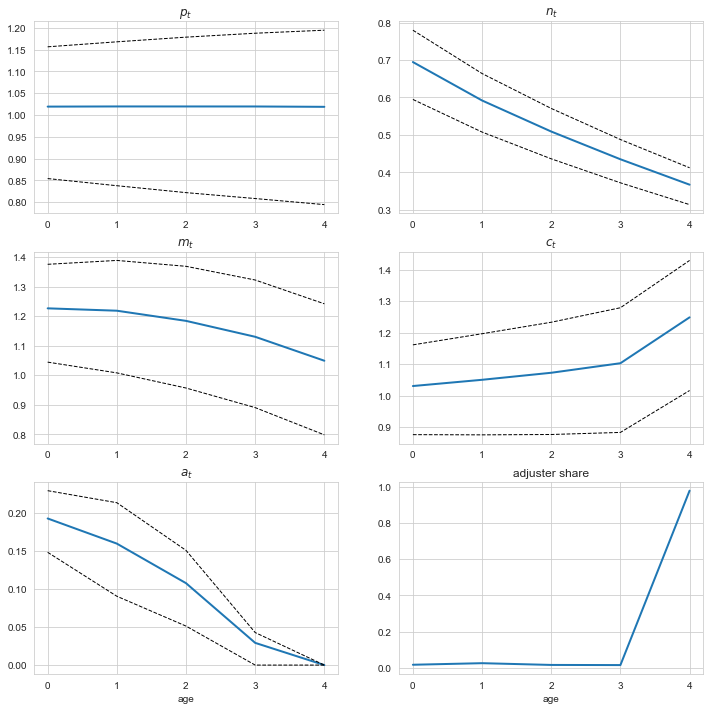

In [10]:
model_negm.lifecycle()

# Compare life-cycles from NVFI and NEGM

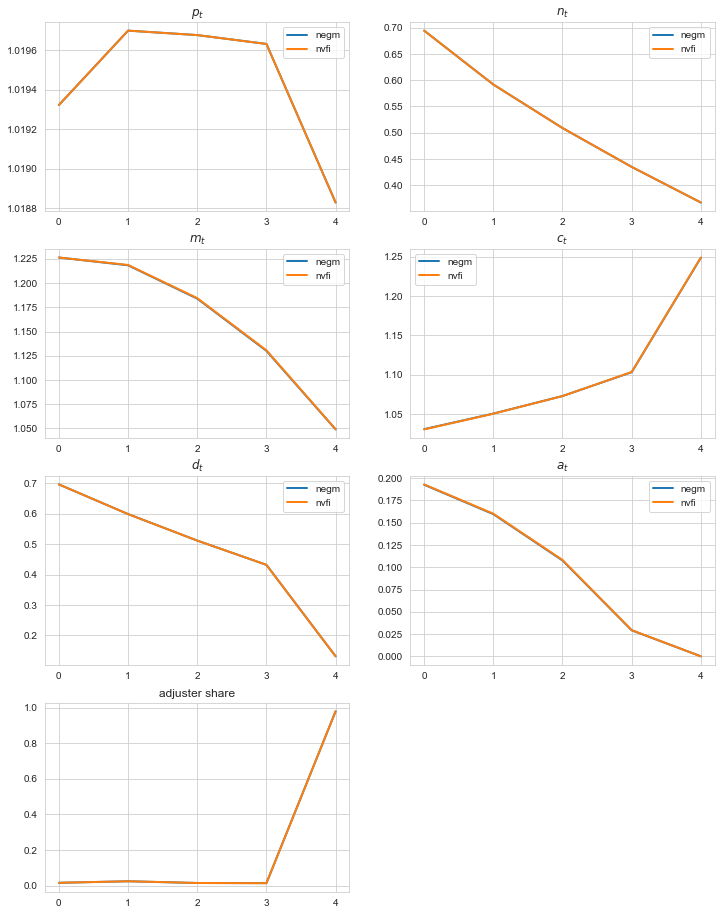

In [11]:
from figs import lifecycle_compare
lifecycle_compare(model_negm,'negm',model_nvfi,'nvfi')

# Compare life-cycle profiles with VFI

In [12]:
model_vfi = DurableConsumptionModelClass(name='example_vfi',par={'solmethod':'vfi','T':T,'do_print':True})
model_vfi.precompile_numba() # solve with very coarse grids
model_vfi.solve()
model_vfi.simulate()
model_vfi.save()

Traceback (most recent call last):
  File "/Users/frederikp/OneDrive - University of Copenhagen/Kandidat/Dynamic Programming/dp2022/ConsumptionSavingCleaned/DurableConsumptionModel.py", line 307, in solve
    post_decision.compute_wq(t,sol,par,compute_q=True)
  File "/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/numba/core/dispatcher.py", line 434, in _compile_for_args
    return_val = self.compile(tuple(argtypes))
  File "/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/numba/core/dispatcher.py", line 979, in compile
    cres = self._compiler.compile(args, return_type)
  File "/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/numba/core/dispatcher.py", line 141, in compile
    status, retval = self._compile_cached(args, return_type)
  File "/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/numba/core/dispatcher.py", line 155, in _compile_cached
    retval = self._compile_core(args, return_type)
  File "/Users/frederikp/opt/anaconda3/lib/python3

KeyboardInterrupt: 

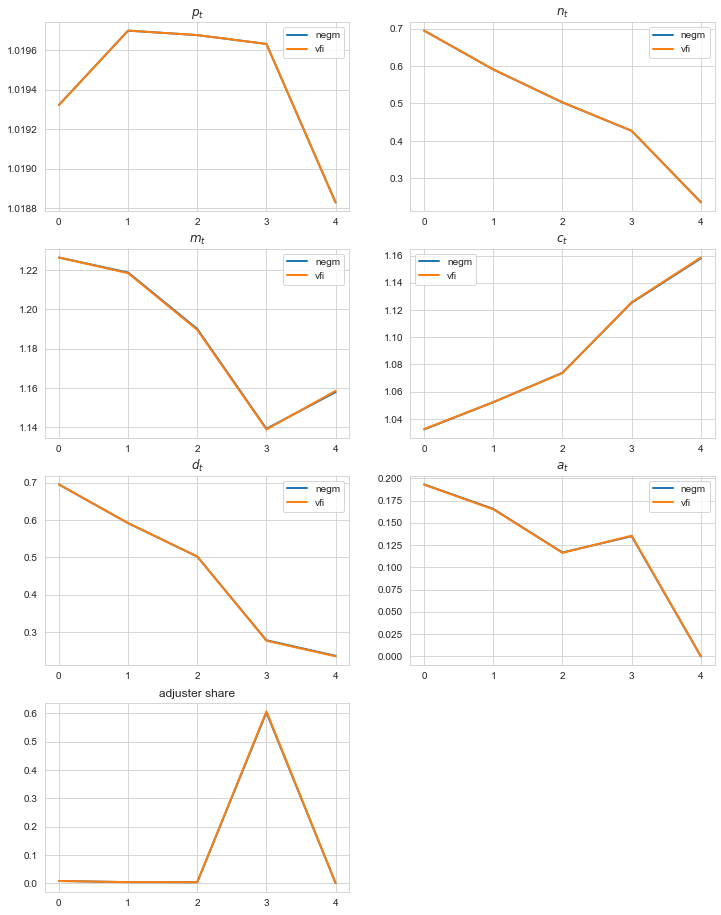

In [ ]:
lifecycle_compare(model_negm,'negm',model_vfi,'vfi')